# 第一章 はじめに

## transformersを使って自然言語処理を解いてみよう

In [1]:
from transformers import pipeline

/Users/t.taniguchi/Library/Caches/pypoetry/virtualenvs/study-lmm-wQFh0UWk-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# テキストがポジティブかネガティブか判定する
# bert-base-japanese-v3-marc_jaは
text_classification_pipeline = pipeline(
    model="llm-book/bert-base-japanese-v3-marc_ja"
    )

positive_text = "世界には言葉がわからなくても感動する音楽がある。"
# positive_textの極性を予測
print(text_classification_pipeline(positive_text)[0])


Device set to use cpu


{'label': 'positive', 'score': 0.9993619322776794}


In [3]:
#negative_textの極性を予測
negative_text = "世界には言葉がでないほどひどい音楽がある。"
print(text_classification_pipeline(negative_text)[0])

{'label': 'negative', 'score': 0.9636250734329224}


In [4]:
# 言語モデルの意味理解能力を評価する
nli_pipeline = pipeline(model="llm-book/bert-base-japanese-v3-jnli")
text = "二人の男性がジェット機を見ています"
entailment_text = "ジェット機を見ている人が二人います"

# textとentailment_textの論理関係を予測
print(nli_pipeline({"text": text, "text_pair": entailment_text}))

Device set to use cpu


{'label': 'entailment', 'score': 0.9964311122894287}


In [5]:
contradiction_text = "二人の男性が飛んでいます"
# textとcontradiction_textの論理関係を予測
print(nli_pipeline({"text": text, "text_pair": contradiction_text}))

{'label': 'contradiction', 'score': 0.9990535378456116}


- entailmentは含意を意味する
- contradictionは矛盾を意味する
- neutralは中立を意味する

「ジェット機を見ている人が二人います」と「二人の男性が飛んでいます」が矛盾？？？

In [6]:
# 意味的類似度計算
text_sim_pipeline = pipeline(
    model="llm-book/bert-base-japanese-v3-jsts",
    function_to_apply="none",
)
text = "川べりでサーフボードを持った人たちがいます"
sim_text = "サーファーたちが川べりに立っています"
# textとsim_textの類似度を計算
result = text_sim_pipeline({"text": text, "text_pair": sim_text})
print(result["score"])

Device set to use cpu


3.5703563690185547


In [7]:
dissim_text = "トイレの壁に黒いタオルがかけられています"
# textとdissim_textの類似度を計算
result = text_sim_pipeline({"text": text, "text_pair": dissim_text})
print(result["score"])

0.04162174463272095


In [8]:
from torch.nn.functional import cosine_similarity

sim_enc_pipeline = pipeline(
    model="llm-book/bert-base-japanese-v3-unsup-simcse-jawiki",
    task="feature-extraction",
)

# textとsim_textのベクトルを獲得
text_emb = sim_enc_pipeline(text, return_tensors=True)[0][0]
sim_emb = sim_enc_pipeline(sim_text, return_tensors=True)[0][0]
# textとsim_textの類似度を計算
sim_pair_score = cosine_similarity(text_emb, sim_emb, dim=0)
print(sim_pair_score.item())

Device set to use cpu


0.8568588495254517


In [9]:
# dissim_textのベクトルを獲得
dissim_emb = sim_enc_pipeline(dissim_text, return_tensors=True)[0][0]
# textとdissim_textの類似度を計算
dissim_pair_score = cosine_similarity(text_emb, dissim_emb, dim=0)
print(dissim_pair_score.item())

0.4588705003261566


In [10]:
from pprint import pprint

ner_pipeline = pipeline(
    model="llm-book/bert-base-japanese-v3-ner-wikipedia-dataset",
    aggregation_strategy="simple",
)
text = "大谷翔平は岩手県水沢市出身のプロ野球選手"
# text中の固有表現を抽出
pprint(ner_pipeline(text))

Device set to use cpu


[{'end': None,
  'entity_group': '人名',
  'score': np.float32(0.99823624),
  'start': None,
  'word': '大谷 翔平'},
 {'end': None,
  'entity_group': '地名',
  'score': np.float32(0.9986874),
  'start': None,
  'word': '岩手 県 水沢 市'}]


In [11]:
text2text_pipeline = pipeline(
    model="llm-book/t5-base-long-livedoor-news-corpus"
)
article = "ついに始まった３連休。テレビを見ながら過ごしている人も多いのではないだろうか？　今夜オススメなのは何と言っても、NHKスペシャル「世界を変えた男 スティーブ・ジョブズ」だ。実は知らない人も多いジョブズ氏の養子に出された生い立ちや、アップル社から一時追放されるなどの経験。そして、彼が追い求めた理想の未来とはなんだったのか、ファンならずとも気になる内容になっている。 今年、亡くなったジョブズ氏の伝記は日本でもベストセラーになっている。今後もアップル製品だけでなく、世界でのジョブズ氏の影響は大きいだろうと想像される。ジョブズ氏のことをあまり知らないという人もこの機会にぜひチェックしてみよう。 世界を変えた男　スティーブ・ジョブズ（NHKスペシャル）"
# articleの要約を生成
print(text2text_pipeline(article)[0]["generated_text"])

Device set to use cpu


今夜はNHKスペシャル「世界を変えた男 スティーブ・ジョブズ」をチェック!


## transformersの基本的な使い方

In [13]:
from transformers import AutoTokenizer

# AutoTokenizerでトークナイザをロードする
tokenizer = AutoTokenizer.from_pretrained("abeja/gpt2-large-japanese")
# 入力文をトークンに分割する
tokenizer.tokenize("今日は天気が良いので")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


['▁', '今日', 'は', '天気', 'が良い', 'の', 'で']

In [14]:
from transformers import AutoModelForCausalLM

# 生成を行うモデルであるAutoModelForCausalLMを使ってモデルをロードする
model = AutoModelForCausalLM.from_pretrained(
    "abeja/gpt2-large-japanese"
)
# トークナイザを使ってモデルへの入力を作成する
inputs = tokenizer("今日は天気が良いので", return_tensors="pt")
# 後続のテキストを予測

In [15]:
outputs = model.generate(
    **inputs,
    max_length=15,  # 生成する最大トークン数を15に指定
    pad_token_id=tokenizer.pad_token_id  # パディングのトークンIDを指定
)
# generate関数の出力をテキストに変換する
generated_text = tokenizer.decode(
    outputs[0], skip_special_tokens=True
)
print(generated_text)

今日は天気が良いので外でお弁当を食べました。


# Transformer 

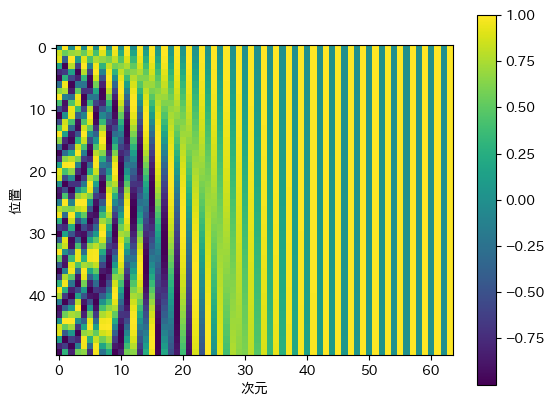

In [17]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

K = 50  # 単語列の最大長
D = 64  # 埋め込みの次元

# 位置符号行列を初期化
pos_enc = np.empty((K, D))

for i in range(K):  # 単語位置iでループ
    for k in range(D // 2):  # kの値でループ
        theta = i / (10000 ** (2 * k / D))
        pos_enc[i, 2 * k] = np.sin(theta)
        pos_enc[i, 2 * k + 1] = np.cos(theta)

# 行列を画像で表示
im = plt.imshow(pos_enc)
plt.xlabel("次元")  # X軸のラベルを設定
plt.ylabel("位置")  # Y軸のラベルを設定
plt.colorbar(im)  # 値と色の対応を示すバーを付加
plt.show()

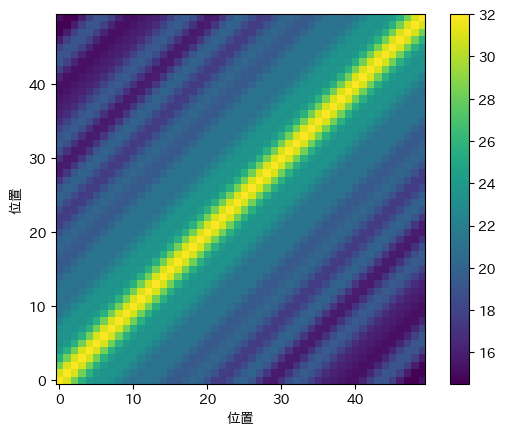

In [18]:
# 位置符号同士の内積を計算
dot_matrix = np.matmul(pos_enc, pos_enc.T)
# 行列を画像で表示
im = plt.imshow(dot_matrix, origin="lower")
plt.xlabel("位置")
plt.ylabel("位置")
plt.colorbar(im)
plt.show()

位置が離れるほど、値が小さくなる。つまり、あるトークンに対して、それに近いトークンほど関連が高いと捉えるようにできている。